 # AD Click Prediction

In [1]:
## importing libraries ##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV , train_test_split
from tqdm import tqdm_notebook
import warnings
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import gc
import featuretools as ft
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = pd.read_csv('train data.csv', parse_dates= ['DateTime'])

In [3]:
test = pd.read_csv('test data.csv', parse_dates = ['DateTime'])

In [4]:
hist = pd.read_csv('historical_user_logs.csv', parse_dates= ['DateTime'])

In [5]:
data.head()

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,140690,2017-07-02 00:00:00,858557,C,359520,13787,4,NaN,10.0,Female,4.0,3.0,3.0,0,0
1,333291,2017-07-02 00:00:00,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0
2,129781,2017-07-02 00:00:00,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0
3,464848,2017-07-02 00:00:00,1097446,I,359520,13787,3,NaN,3.0,Male,3.0,3.0,2.0,1,0
4,90569,2017-07-02 00:01:00,663656,C,405490,60305,3,NaN,2.0,Male,2.0,3.0,2.0,1,0


In [6]:
hist.head()

,DateTime,user_id,product,action
0,2017-05-28 15:44:00,704,B,view
1,2017-05-29 07:08:00,499679,F,view
2,2017-05-29 07:10:00,499679,G,view
3,2017-05-29 07:10:00,499679,G,view
4,2017-05-29 07:10:00,499679,G,view


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463291 entries, 0 to 463290
Data columns (total 15 columns):
session_id                463291 non-null int64
DateTime                  463291 non-null datetime64[ns]
user_id                   463291 non-null int64
product                   463291 non-null object
campaign_id               463291 non-null int64
webpage_id                463291 non-null int64
product_category_1        463291 non-null int64
product_category_2        97437 non-null float64
user_group_id             445048 non-null float64
gender                    445048 non-null object
age_level                 445048 non-null float64
user_depth                445048 non-null float64
city_development_index    338162 non-null float64
var_1                     463291 non-null int64
is_click                  463291 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(7), object(2)
memory usage: 53.0+ MB


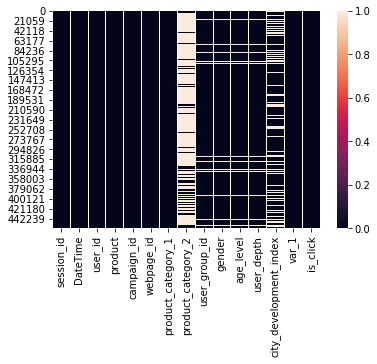

In [8]:
sns.heatmap(data.isnull())

### Data Imputation

In [6]:
# data imputation
data = data.drop('product_category_2', axis = 1) # dropping the column 
# for rest of the columns with missing values, imputing using forward fill.
data['city_development_index'] = data['city_development_index'].fillna(method = 'ffill') 
data['gender'] = data['gender'].fillna(method = 'ffill')
data['user_group_id'] = data['user_group_id'].fillna(method = 'ffill')
data['age_level'] = data['age_level'].fillna(method = 'ffill')
data['user_depth'] = data['user_depth'].fillna(method = 'ffill')

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463291 entries, 0 to 463290
Data columns (total 14 columns):
session_id                463291 non-null int64
DateTime                  463291 non-null datetime64[ns]
user_id                   463291 non-null int64
product                   463291 non-null object
campaign_id               463291 non-null int64
webpage_id                463291 non-null int64
product_category_1        463291 non-null int64
user_group_id             463291 non-null float64
gender                    463291 non-null object
age_level                 463291 non-null float64
user_depth                463291 non-null float64
city_development_index    463291 non-null float64
var_1                     463291 non-null int64
is_click                  463291 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(7), object(2)
memory usage: 49.5+ MB


### Data Visualization

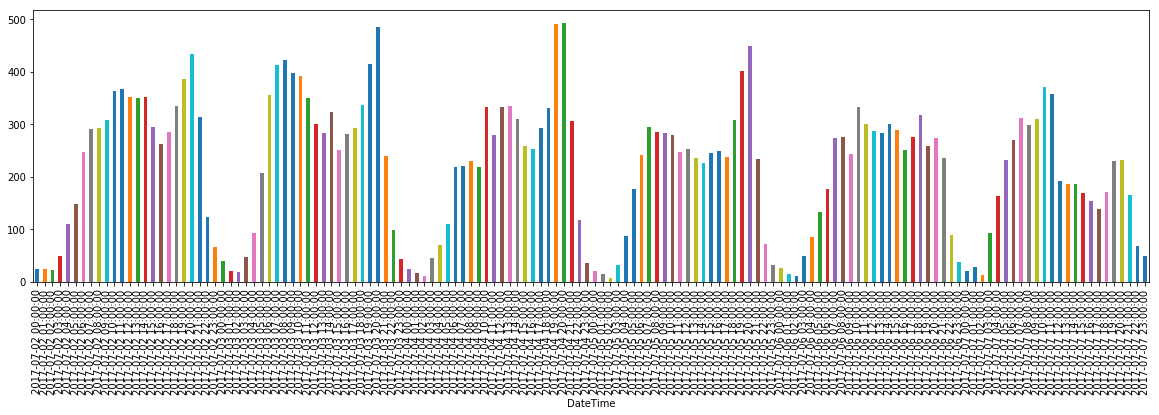

In [11]:
day = data.groupby('DateTime')['is_click'].sum()
day = day.resample('H').sum()
plt.figure(figsize=(20,5))
day.plot(kind='bar',grid = None)

#### Visualizing the trends in the data by setting granularity to per hour on daily basis.

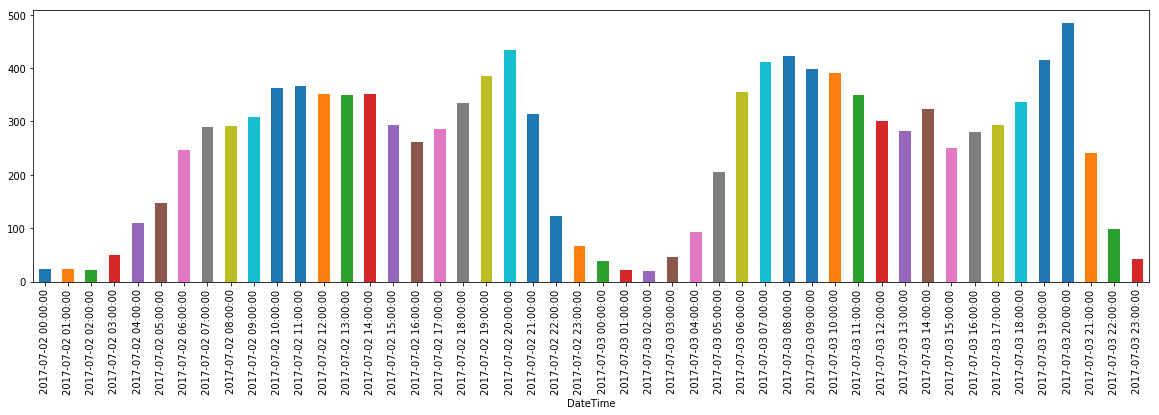

In [12]:
part_day = day.loc[slice('2017-07-02','2017-07-03')]
plt.figure(figsize=(20,5))
part_day.plot(kind='bar',grid = None)

#### Portion of the above plot for 2 days of user data.

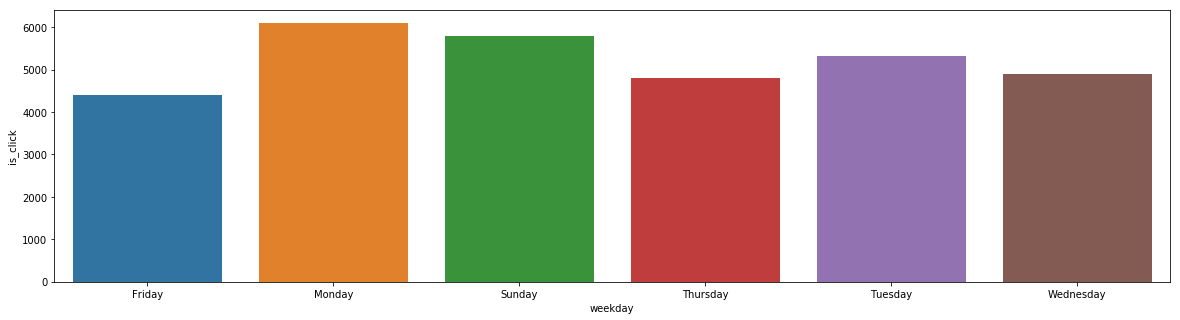

In [13]:
data1 = data.reset_index()
data1['weekday'] = data1['DateTime'].dt.day_name()
byday  = pd.DataFrame(data1.groupby('weekday')['is_click'].sum())
byday = byday.reset_index()
plt.figure(figsize=(20,5))
sns.barplot(data = byday , x= 'weekday', y = 'is_click')

#### Visualizing the user behavior on weekday basis. It seems that most of the clicks are for MONDAY & SUNDAY.

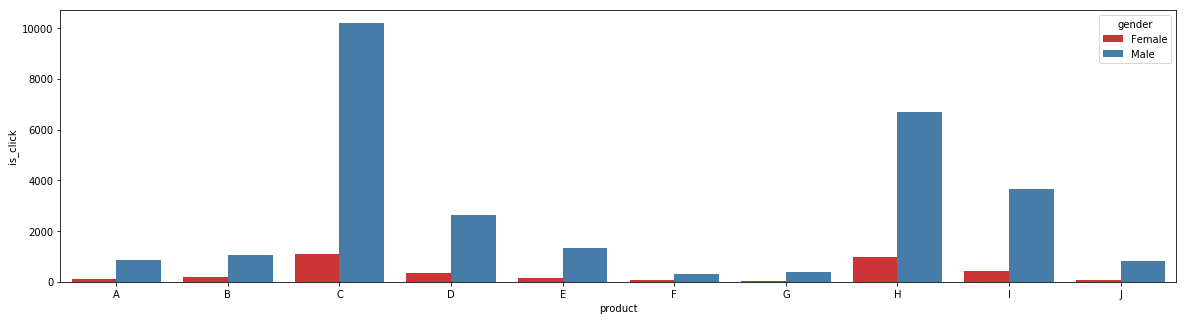

In [14]:
user = data.groupby(['gender','product'])['is_click'].sum()
user = pd.DataFrame(user.reset_index())
plt.figure(figsize=(20,5))
sns.barplot(data = user, x= 'product', y = 'is_click', hue = 'gender',palette='Set1')

#### Visualizing data for different products for male and female user groups.

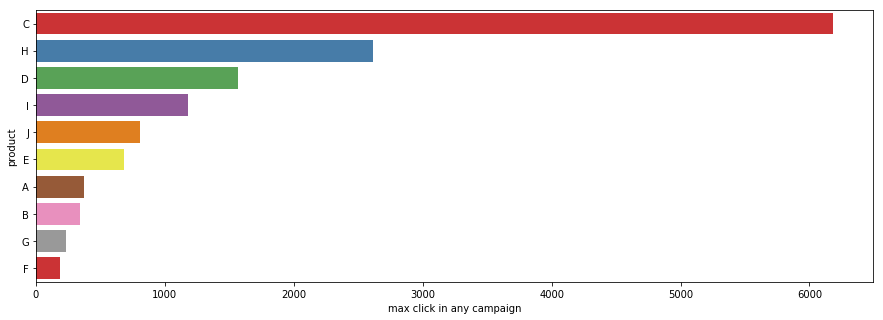

In [15]:
n_data = data.reset_index()
campaign= pd.DataFrame(n_data.groupby(['campaign_id','product'])['is_click'].sum())
campaign= campaign.reset_index()
campaign= campaign.groupby(['product'])[['campaign_id','is_click']].max()
campaign= campaign.sort_values('is_click',ascending = False).reset_index()
campaign.columns = ['product', 'campaign_id', 'max click in any campaign']
plt.figure(figsize=(15,5))
sns.barplot(y= 'product', x= 'max click in any campaign', palette = 'Set1', data = campaign, orient='h')

#### Barplot showing max clicks for all the product from a single campaign.

In [16]:
n_data = data.reset_index()
campaign= pd.DataFrame(n_data.groupby(['campaign_id','product'])['is_click'].sum())
campaign= campaign.reset_index()
campaign= campaign.groupby('campaign_id')[['product','is_click']].max()
campaign.sort_values('is_click',ascending = False)

,product,is_click
campaign_id,,
405490,H,6183
359520,I,2796
98970,I,1566
360936,I,1293
396664,J,1182
118601,I,816
404347,J,805
105960,I,749
414149,I,610


#### Table highlighting the most successful product and no. of clicks for each of them for each campaign.

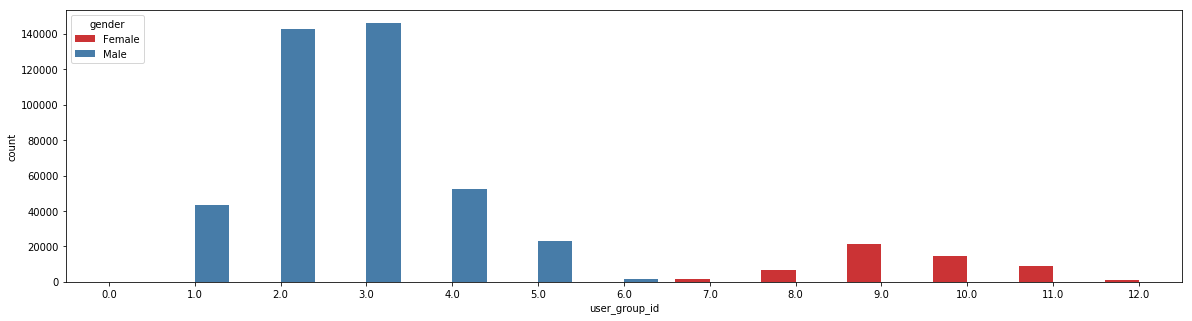

In [17]:
plt.figure(figsize=(20,5))
sns.countplot(x= 'user_group_id', hue= 'gender', palette = 'Set1', data = data)

#### This visualization highlights that all the user groups from 0-6 are Male and from 7-12 are Females.

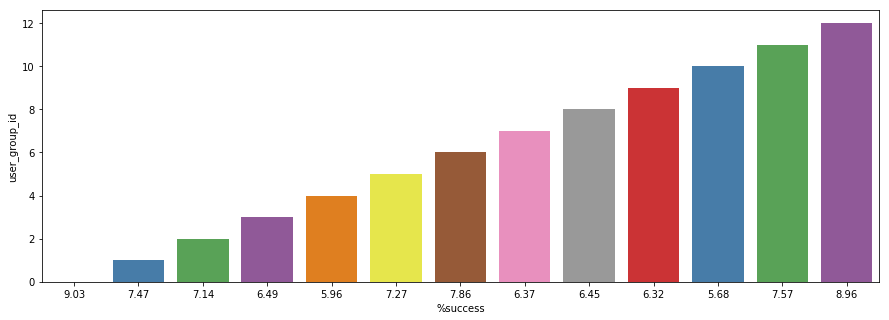

In [18]:
plt.figure(figsize=(15,5))
user_group = data.groupby('user_group_id')['is_click'].agg(['count','sum'])
user_group['%success']= round((user_group['sum']*100)/user_group['count'], 2)
user_group = user_group.reset_index()
sns.barplot(y= 'user_group_id', x= '%success', data = user_group, palette = 'Set1', order = user_group['%success'])

#### successs % on the basis of the user id group. Most successful user group is 12.

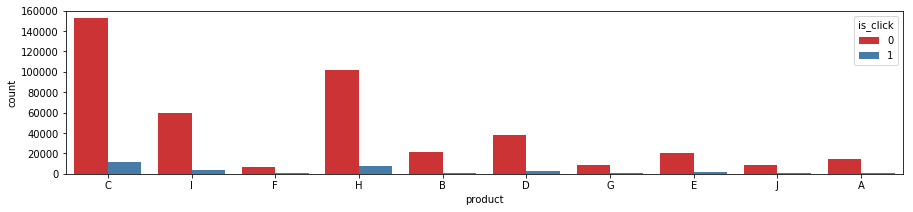

In [19]:
plt.figure(figsize=(15,3))
sns.countplot(x="product", hue= "is_click", palette = 'Set1', data =data )

#### Visualizing count of clicks and non clicks for each of the product.

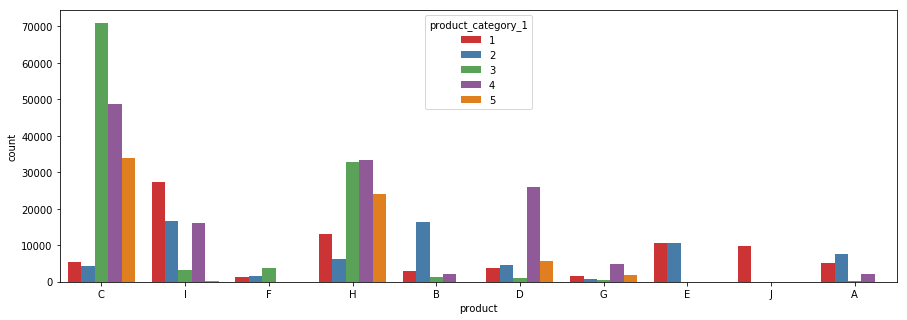

In [20]:
plt.figure(figsize=(15,5))
sns.countplot(x="product", hue= "product_category_1", palette = 'Set1', data =data)

#### Performance of all the products compared category wise.

In [21]:
data1 = data[['user_depth', 'is_click']]
data1 = data.groupby(['user_depth','is_click']).size().unstack()
data1['success %'] = round(data1[1]*100/(data1[1]+data1[0]),2)
data1

is_click,0,1,success %
user_depth,,,
1.0,11465,878,7.11
2.0,29523,2070,6.55
3.0,390972,28383,6.77


In [22]:
print(data['is_click'].value_counts())
print(round(30057*100/(414991),2))  

0    431960
1     31331
Name: is_click, dtype: int64
7.24


### Number of clicks is only 7.24%. So, our dataset is imbalanced

### Feature Engineering & Data Preprocessing

In [7]:
data['weekday']=data['DateTime'].dt.day_name()
data['hour'] = data['DateTime'].dt.hour
data['minutes'] = data['DateTime'].dt.minute
data = data.drop(['DateTime','session_id'], axis = 1)
data.head()

,user_id,product,campaign_id,webpage_id,product_category_1,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click,weekday,hour,minutes
0,858557,C,359520,13787,4,10.0,Female,4.0,3.0,3.0,0,0,Sunday,0,0
1,243253,C,105960,11085,5,8.0,Female,2.0,2.0,3.0,0,0,Sunday,0,0
2,243253,C,359520,13787,4,8.0,Female,2.0,2.0,3.0,0,0,Sunday,0,0
3,1097446,I,359520,13787,3,3.0,Male,3.0,3.0,2.0,1,0,Sunday,0,0
4,663656,C,405490,60305,3,2.0,Male,2.0,3.0,2.0,1,0,Sunday,0,1


In [8]:
es1 = ft.EntitySet()

In [9]:
es1 = es1.entity_from_dataframe(entity_id= 'hist', 
                                dataframe= hist,
                                make_index = True,
                                index = 'id',
                                time_index = 'DateTime',
                                variable_types={"user_id": ft.variable_types.Categorical})
                                       

In [10]:
es1['hist'].variables

[<Variable: id (dtype = index)>,
 <Variable: DateTime (dtype: datetime_time_index, format: None)>,
 <Variable: product (dtype = categorical)>,
 <Variable: action (dtype = categorical)>,
 <Variable: user_id (dtype = categorical)>]

In [11]:
es1 = es1.entity_from_dataframe(entity_id = 'data', 
                                dataframe= data, 
                                make_index= True, 
                                index = 'id',
                                variable_types={"user_id": ft.variable_types.Categorical, 
                                                'webpage_id': ft.variable_types.Categorical,
                                                'campaign_id': ft.variable_types.Categorical,
                                                'product_category_1': ft.variable_types.Categorical,
                                                'user_group_id':  ft.variable_types.Categorical,
                                                'age_level': ft.variable_types.Categorical,
                                                'user_depth': ft.variable_types.Categorical,
                                                'city_development_index': ft.variable_types.Categorical,
                                                'var_1': ft.variable_types.Categorical ,
                                                'is_click': ft.variable_types.Categorical
                                               })          

In [12]:
es1['data'].variables

[<Variable: id (dtype = index)>,
 <Variable: product (dtype = categorical)>,
 <Variable: gender (dtype = categorical)>,
 <Variable: weekday (dtype = categorical)>,
 <Variable: hour (dtype = numeric)>,
 <Variable: minutes (dtype = numeric)>,
 <Variable: user_id (dtype = categorical)>,
 <Variable: webpage_id (dtype = categorical)>,
 <Variable: campaign_id (dtype = categorical)>,
 <Variable: product_category_1 (dtype = categorical)>,
 <Variable: user_group_id (dtype = categorical)>,
 <Variable: age_level (dtype = categorical)>,
 <Variable: user_depth (dtype = categorical)>,
 <Variable: city_development_index (dtype = categorical)>,
 <Variable: var_1 (dtype = categorical)>,
 <Variable: is_click (dtype = categorical)>]

In [13]:
relation = ft.Relationship(es1['data']['id'], es1['hist']['id'])

In [14]:
es1 = es1.add_relationship(relation)
es1

Entityset: None
  Entities:
    hist [Rows: 24287534, Columns: 5]
    data [Rows: 463291, Columns: 16]
  Relationships:
    hist.id -> data.id

In [15]:
features, feature_names = ft.dfs(entityset= es1, 
                                 target_entity= 'data', 
                                  max_depth = 2
                                 )

In [16]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463291 entries, 0 to 463290
Data columns (total 29 columns):
product                               463291 non-null object
gender                                463291 non-null object
weekday                               463291 non-null object
hour                                  463291 non-null int64
minutes                               463291 non-null int64
user_id                               463291 non-null int64
webpage_id                            463291 non-null int64
campaign_id                           463291 non-null int64
product_category_1                    463291 non-null int64
user_group_id                         463291 non-null float64
age_level                             463291 non-null float64
user_depth                            463291 non-null float64
city_development_index                463291 non-null float64
var_1                                 463291 non-null int64
is_click                              

In [17]:
col =['product','gender','weekday','webpage_id','campaign_id','product_category_1','user_group_id','age_level','user_depth','var_1','city_development_index','MODE(hist.product)','MODE(hist.action)']
new_data = pd.get_dummies(features, columns = col, drop_first= True)

In [18]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463291 entries, 0 to 463290
Data columns (total 86 columns):
hour                                  463291 non-null int64
minutes                               463291 non-null int64
user_id                               463291 non-null int64
is_click                              463291 non-null int64
NUM_UNIQUE(hist.product)              463291 non-null int64
NUM_UNIQUE(hist.action)               463291 non-null int64
NUM_UNIQUE(hist.user_id)              463291 non-null int64
MODE(hist.user_id)                    463291 non-null int64
NUM_UNIQUE(hist.DAY(DateTime))        463291 non-null int64
NUM_UNIQUE(hist.YEAR(DateTime))       463291 non-null int64
NUM_UNIQUE(hist.MONTH(DateTime))      463291 non-null int64
NUM_UNIQUE(hist.WEEKDAY(DateTime))    463291 non-null int64
MODE(hist.DAY(DateTime))              463291 non-null int64
MODE(hist.YEAR(DateTime))             463291 non-null int64
MODE(hist.MONTH(DateTime))            463291 non-

In [19]:
X = new_data.drop('is_click', axis=1)
y = new_data['is_click']

In [20]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3,  stratify = y,random_state = 101)

In [21]:
train = pd.concat([X_train, y_train], axis = 1)

In [23]:
t_0 = train[train['is_click'] == 0]
t_1 = train[train['is_click'] == 1]

#### Working with a subset of Training Data

In [24]:
t0_sub = t_0.sample(n = 27573, random_state= 101)
t1_sub = t_1.sample(n = 2000, random_state= 101)
train_sub = pd.concat([t0_sub,t1_sub], axis = 0)
train_sub = train_sub.sample(frac=1, random_state= 101)

In [25]:
Xtr_sub = train_sub.drop('is_click', axis=1)
ytr_sub = train_sub['is_click']

In [26]:
from imblearn.over_sampling import SMOTE

In [27]:
sm = SMOTE(random_state = 101)
X_sub, y_sub  = sm.fit_sample(Xtr_sub,ytr_sub)

In [28]:
X_sub.shape, y_sub.shape

((55146, 85), (55146,))

#### Feature Selection

In [29]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [30]:
model = LogisticRegression()
rfe = RFE(model, n_features_to_select=75, verbose= 1)
fit = rfe.fit(X_sub,y_sub)

Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.


In [31]:
sum(fit.support_)

75

In [32]:
X_sub = pd.DataFrame(X_sub, columns= Xtr_sub.columns)
X_sub = np.array(X_sub.loc[:,fit.support_])
X_sub.shape

(55146, 75)

In [76]:
X_test = np.array(X_test.loc[:,fit.support_])

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [33]:
type(X_sub)

numpy.ndarray

In [34]:
y_pred = fit.predict(X_test)
matrix =classification_report(y_test,y_pred)
print(matrix)

              precision    recall  f1-score   support

           0       0.94      0.55      0.70    129589
           1       0.08      0.55      0.14      9399

   micro avg       0.55      0.55      0.55    138988
   macro avg       0.51      0.55      0.42    138988
weighted avg       0.89      0.55      0.66    138988



In [35]:
confusion_matrix(y_test,y_pred)

array([[71325, 58264],
       [ 4219,  5180]], dtype=int64)

In [36]:
roc_auc_score(y_test,y_pred)

0.5507581987966078

#### 75 features seems to be optimum

#### Logistic Regreession is our base model with roc_auc score of 0.55

### Data Modelling

In [38]:
def best_model(estimator,grid, refit_score, scorer):
    grid_search = GridSearchCV(estimator, param_grid=grid, scoring= scorer, refit= refit_score, cv = skf,n_jobs= -1)
    grid_search.fit(X_sub, y_sub)
    
    pred = grid_search.predict(X_test)
    
    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)
    
    print(pd.DataFrame(confusion_matrix(y_test, pred),columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    
    print('roc-auc : %0.2f'  % roc_auc_score(y_test, pred))
    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    return grid_search

In [39]:
skf = StratifiedKFold(n_splits=5, random_state=101)
scorers = ['recall']

#### Decision Tree

In [74]:
from sklearn.tree import DecisionTreeClassifier

In [75]:
dctree = DecisionTreeClassifier()

In [76]:
para_grid = {
    'criterion': ['entropy', 'gini'],
    'min_samples_split': [2],
    'max_depth': [30,35,40],
    'max_features': [20, 25,27]
}

In [77]:
best_model(estimator= dctree, grid= para_grid, refit_score= 'recall', scorer= scorers)

Best params for recall
{'criterion': 'entropy', 'max_depth': 35, 'max_features': 25, 'min_samples_split': 2}
     pred_neg  pred_pos
neg    119765      9824
pos      8628       771
roc-auc : 0.50


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=101, shuffle=False),
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'criterion': ['entropy', 'gini'], 'min_samples_split': [2], 'max_depth': [30, 35, 40], 'max_features': [20, 25, 27]},
       pre_dispatch='2*n_jobs', refit='recall', return_train_score='warn',
       scoring=['recall'], verbose=0)

#### Random Forest

In [92]:
from sklearn.ensemble import RandomForestClassifier

In [93]:
rf = RandomForestClassifier()

In [106]:
para_grid = {
    'min_samples_split': [2], 
    'n_estimators' : [300],
    'max_depth': [25],
    'max_features': [40, 45],
}

In [107]:
best_model(estimator= rf, grid= para_grid, refit_score= 'recall', scorer= scorers)

Best params for recall
{'max_depth': 25, 'max_features': 45, 'min_samples_split': 2, 'n_estimators': 300}
     pred_neg  pred_pos
neg    129374       215
pos      9379        20
roc-auc : 0.50


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=101, shuffle=False),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'min_samples_split': [2], 'n_estimators': [300], 'max_depth': [25], 'max_features': [40, 45]},
       pre_dispatch='2*n_jobs', refit='recall', return_train_score='warn',
       scoring=['recall'], verbose=0)

#### Thus, we can see a simple model sometimes give better results than complex algorithms.